In [34]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

In [35]:
def read_background_file(root_file_path):
    with uproot.open(root_file_path) as root_file:
        event_tree = root_file["event_tree"]
        hit_tree = root_file["hit_tree"]
        photons_tree = root_file["arrival_photons_tree"]

        total_optical_photons = event_tree["total_optical_photons"].array()
        total_thermal_electrons = event_tree["total_thermal_electrons"].array()

        hit_times = hit_tree["hit_times"].array()
        hit_total_energy_deposits = hit_tree["hit_total_energy_deposit"].array()

        sensor_count = photons_tree["sensor_count"].array()

        return total_optical_photons, total_thermal_electrons, hit_times, hit_total_energy_deposits, sensor_count
    
def prepare_dataset(*args):
    """Convert lists of arrays into a 2D numpy array."""
    
    processed_arrays = []
    
    for arrays in args:
        if isinstance(arrays[0], (np.number, float, int)):
            processed_arrays.append(arrays)
        else:
            processed_summary = [np.mean(arr) if len(arr) > 0 else 0 for arr in arrays]
            processed_arrays.append(processed_summary)
    
    return np.column_stack(processed_arrays)


In [36]:
base_path = "/home/lane/Software/src/lumilar/system/data/"

file_names = [
    "bxdecay0_Ar39",
    "bxdecay0_Ar42",
    "bxdecay0_K42",
    "bxdecay0_Bi214",
    "bxdecay0_Kr85",
    "bxdecay0_Pb214",
    "bxdecay0_Rn222",
    "marley_B8_CC",
    "marley_B8_ES",
    "marley_HEP_CC",
    "marley_HEP_ES",
]

data_dict = {}

for name in file_names:
    path = f"{base_path}{name}.root"
    data = read_background_file(path)
    
    data_dict[name] = {
        'photons': data[0],
        'electrons': data[1],
        'times': data[2],
        'energy': data[3],
        'sensor_count': data[4]
    }

In [37]:
backgrounds = [
    prepare_dataset(data_dict["bxdecay0_Bi214"]['sensor_count']),
]

x_background = np.vstack(backgrounds)
y_background = np.zeros(len(x_background))

signals = [
    prepare_dataset(data_dict["marley_B8_CC"]['sensor_count']),
    prepare_dataset(data_dict["marley_HEP_CC"]['sensor_count']),
]

x_signal = np.vstack(signals)
y_signal = np.ones(len(x_signal))

X = np.vstack([x_background, x_signal])
Y = np.concatenate([y_background, y_signal])

Accuracy: 73.77%
Particle: 0.0
Probability: [0.49164218 0.5572058  0.00273007 ... 0.09046429 0.21284187 0.11927676]
Particle: 1.0
Probability: [0.5083578  0.44279417 0.9972699  ... 0.9095357  0.78715813 0.88072324]


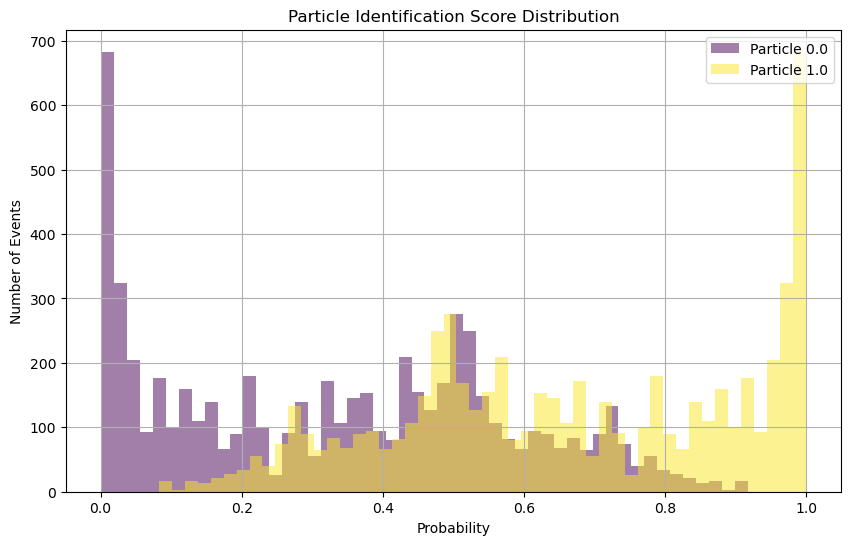

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

clf = xgb.XGBClassifier()
clf.fit(X_train, Y_train)
accuracy = clf.score(X_test, Y_test)

print(f"Accuracy: {accuracy*100:.2f}%")

probabilities = clf.predict_proba(X_test)

plt.figure(figsize=(10, 6))
particle_types = clf.classes_  
colors = plt.cm.viridis(np.linspace(0, 1, len(particle_types)))

for idx, ptype in enumerate(particle_types):
    print(f"Particle: {ptype}")
    print(f"Probability: {probabilities[:, idx]}")
    plt.hist(probabilities[:, idx], bins=50, alpha=0.5, label=f"Particle {ptype}", color=colors[idx])

plt.legend(loc='upper right')
plt.xlabel('Probability')
plt.ylabel('Number of Events')
plt.title('Particle Identification Score Distribution')
plt.grid(True)
plt.show()

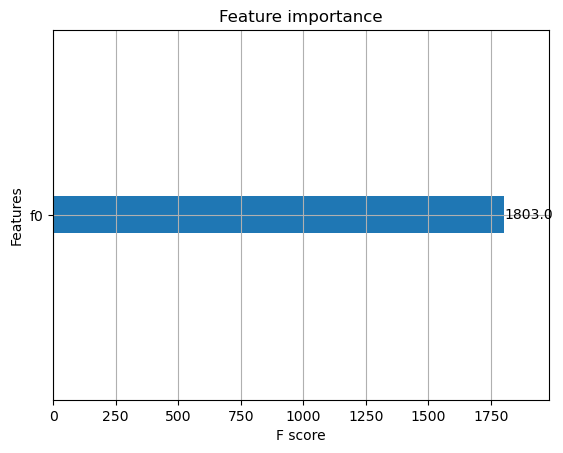

In [39]:
xgb.plot_importance(clf)
plt.show()

In [41]:
param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [1000],
    'max_depth': [10],
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'min_child_weight': [5]
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X, Y)

best_clf = grid_search.best_estimator_

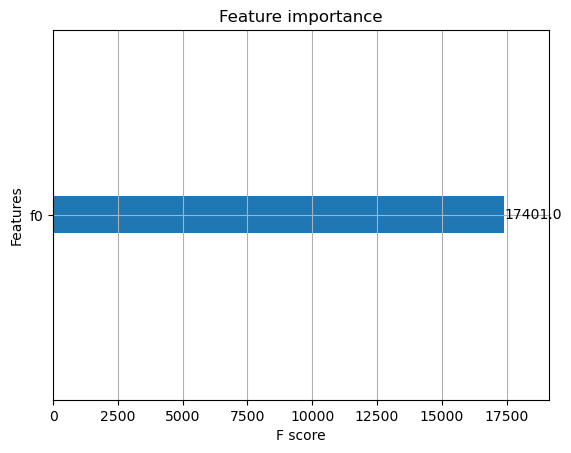

In [42]:
xgb.plot_importance(best_clf)
plt.show()

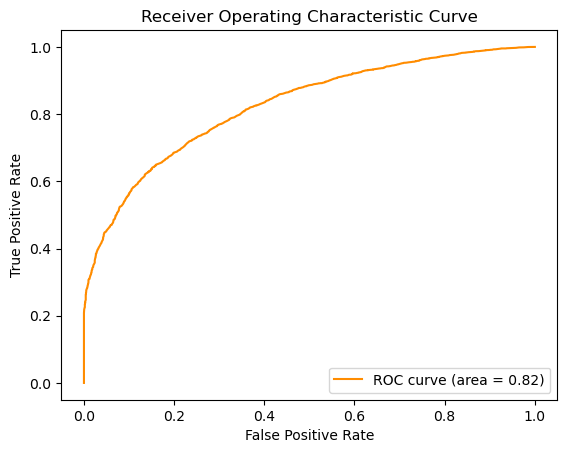

In [43]:
from sklearn.metrics import roc_curve, auc

# Assuming you've split your data into train and test sets.
y_pred_prob = best_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


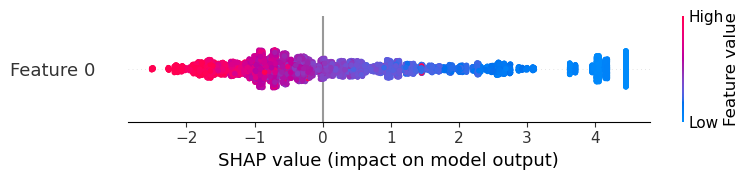

In [46]:
import shap

explainer = shap.Explainer(best_clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)
